# <center>Exploring the Possibility of Creating New Recipes Using Machine Learning</center>

Cooking recipes are about the combination of flavors. The flavors include the natural flavors of food materials themselves and the flavors of seasoners. Some combinations are delicious, while others can be horrible. In 2016, Kiddon et. al., created coherent recipes given all ingredients and a recipe name utilizing a neural checklist model [1]. In 2019, Bodhisattwa, et. al., built a machine learning model to generate personalized recipes from incomplete input specifications and user histories based on the data collected from food.com [2]. In this work, we are more focusing on utilizing machine learning to summarize the good combination of food natural flavors and seasonings, and to explore the possibility of creating new recipes which are potentially able to get great reviews. We are also going to actually cook the predicted new recipes to verify whether they are delicious. 

### Data Collection, Wrangling, and Exploratory Analysis

We obtained one set of recipe and review data from kaggle.com [3]. The data set includes a recipe table and a review table, and two of them are linked through RecipeID.  

In [1]:
######################################
# Importing all necessary packages
######################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import sklearn
import pickle
from collections import defaultdict
from pytimeparse.timeparse import timeparse
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.dpi']=120
plt.rcParams["font.family"] = "arial"

We firstly loaded the recipe data, and converting the data set to a pandas DataFrame. The data set is not clean, therefore a direct call of pd.read_csv() will raise errors. We manually parsed the data set line by line.

The data set is delimited by semicolons. According to the header, there should be 10 columns in each observation. However, some observations has a number of items larger than 10. We guessed that users might put some extra semicolons somewhere. We are going to figure it out. 

In [272]:
##########################################################
# Display the column names of the recipes.csv from header
##########################################################
with open('..\\data\\raw\\recipes.csv', 'r') as file:
    recipe_column_name=pd.Series([string.strip() for string in file.readline().split(';')])
recipe_column_name

0     Recipe Name
1        RecipeID
2    Review Count
3    Recipe Photo
4          Author
5    Prepare Time
6       Cook Time
7      Total Time
8     Ingredients
9      Directions
dtype: object

In [273]:
########################################
# Loading recipes.csv
# Reading all the lines in
########################################
lines=[] # A list of lists
with open('..\\data\\raw\\recipes.csv', 'r') as file:
    content=file.readlines()
    for line in content:
        lines.append([item.strip() for item in line.split(';')])
print('Numbers of items in each line after splited by semicolon:')
set([len(ele) for ele in lines])

Numbers of items in each line after splited by semicolon:


{1, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23}

In [274]:
##############################################################################################################
# For each observation, there are four conditions:
# length=1: an empty line
# 1<length<10 or the second element is not a number: this content belongs to the previous line
# length=10 and the second element is a number (RecipeID): a perfect observation
# length>10 and the second element is a number (RecipeID): some users wrote extra semicolons somewhere and 
# wrongly separated one column into several items
##############################################################################################################
# Firstly, handle the condition of length=1 and 1<length<10
##############################################################################################################
cleaned_lines=[]
for line in lines:
    if len(line)>=10 and line[1].isnumeric():
        cleaned_lines.append(line)
    elif (len(cleaned_lines)>0 and len(line)<10 and len(line)>1) or (len(cleaned_lines)>0 and len(line)>=2 and not line[1].isnumeric()): 
        cleaned_lines[-1]=cleaned_lines[-1]+line
    else:
        pass
##############################################################################################################
cleaned_lines=[ele for ele in cleaned_lines if ele[0]!='Recipe Name']
print('There are {} recipes observed.'.format(len(cleaned_lines)))

There are 18453 recipes observed.


In [275]:
#####################################################
# Secondly, handle the condition of length>=10
#####################################################
recipes_dict=defaultdict(list)
for line in tqdm.tqdm(cleaned_lines):
    if len(line)>=10:
        assert line[1].isnumeric()
        # To check whether there are semicolons in Recipe Name, and the answer is no.
        assert line[5].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[5]=='X'
        assert line[6].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[6]=='X'
        assert line[7].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric() or line[7]=='X'
        assert not line[8].replace('d', '').replace('h', '').replace('m', '').replace(' ', '').isnumeric()
        # To check whether there are semicolons in Author column and three time columns, and the answer is no.
        # Therefore, the extra semicolons should be in either Ingredients column or Directions column
        # Count how many words in each segment in Ingredients column or Directions column
        word_count=[]
        for i in range(8, len(line)):
            word_count.append(len(line[i].split(' ')))
        # Here we made a simple assumption that the Diretion column should have most number of words 
        # disregarding the first ingredient column.
        # We care more about ingredients than directions, so it's OK to get more words from directions
        # to ingredients
        directions_index=np.argmax(word_count[1:])+9
        ingredients=''.join(line[8:directions_index])
        directions=''.join(line[directions_index:])
        new_line=line[:8]+[ingredients]+[directions]
        line=new_line
        assert len(line)==10
        # Now the column number of each observation is right
        for index, column_name in recipe_column_name.items():
            recipes_dict[column_name].append(line[index])
len(recipes_dict['Recipe Name'])

100%|██████████████████████████████████████████████████████████████████████████| 18453/18453 [00:02<00:00, 8445.30it/s]


18453

In [507]:
####################################################################
# Generating recipe data frame
# It seems that there are duplicated records. If recipe names and authers
# are the same, we consider they are duplicated.
####################################################################
recipes=pd.DataFrame(recipes_dict).drop_duplicates(subset=['Recipe Name', 'Author'], keep='first', ignore_index=True)
print('{} lines of duplicated recipes were dropped.'.format(len(recipes_dict['Recipe Name'])-len(recipes.index)))
recipes.info()

447 lines of duplicated recipes were dropped.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18006 entries, 0 to 18005
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Recipe Name   18006 non-null  object
 1   RecipeID      18006 non-null  object
 2   Review Count  18006 non-null  object
 3   Recipe Photo  18006 non-null  object
 4   Author        18006 non-null  object
 5   Prepare Time  18006 non-null  object
 6   Cook Time     18006 non-null  object
 7   Total Time    18006 non-null  object
 8   Ingredients   18006 non-null  object
 9   Directions    18006 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB


In [508]:
################################################################################################################
# Regarding recipes:
# 1. Drop recipes without ingredient information
# 2. Convert RecipeID and review count to ingeters
# 3. Fill missing values with NaN for columns: Recipe Photo, Author, Ingredients, Directions
# 4. Convert Prepare Time, Cook Time, and Total Time to timedelta object, and to fill missing values with NaT
################################################################################################################
recipes_updated=recipes.drop(recipes[recipes['Ingredients']==''].index)
recipes_updated['RecipeID']=recipes['RecipeID'].apply(lambda x: int(x))
recipes_updated['Review Count']=recipes['Review Count'].apply(lambda x: int(x.replace('k', '000')))
recipes_updated['Recipe Photo']=recipes['Recipe Photo'].apply(lambda x: x if x!='X' else np.NaN)
recipes_updated['Author']=recipes['Author'].apply(lambda x: x if x!='X' else np.NaN)
recipes_updated['Prepare Time']=recipes['Prepare Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated['Cook Time']=recipes['Cook Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated['Total Time']=recipes['Total Time'].apply(lambda x: timedelta(seconds=timeparse(x.replace(' ', ''))) if x!='X' else pd.NaT)
recipes_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17175 entries, 0 to 18005
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Recipe Name   17175 non-null  object         
 1   RecipeID      17175 non-null  int64          
 2   Review Count  17175 non-null  int64          
 3   Recipe Photo  17175 non-null  object         
 4   Author        17175 non-null  object         
 5   Prepare Time  11843 non-null  timedelta64[ns]
 6   Cook Time     9889 non-null   timedelta64[ns]
 7   Total Time    11937 non-null  timedelta64[ns]
 8   Ingredients   17175 non-null  object         
 9   Directions    17175 non-null  object         
dtypes: int64(2), object(5), timedelta64[ns](3)
memory usage: 1.4+ MB


The second step is loading the review data, and converting the data set to a pandas DataFrame. The data set is also not clean, therefore a direct call of pd.read_csv() will raise errors either. We manually parsed the data set line by line and did the same operation as for recipes.

In [509]:
##########################################################
# Display the column names of the reviews.csv from header
##########################################################
with open('..\\data\\raw\\reviews.csv', 'r') as file:
    review_column_name=pd.Series([string.strip() for string in file.readline().split(';')])
review_column_name

0     RecipeID
1    profileID
2         Rate
3      Comment
dtype: object

In [510]:
########################################
# Loading reviews.csv
# Reading all the lines in
########################################
lines_review=[] # A list of lists
with open('..\\data\\raw\\reviews.csv', 'r') as file:
    content=file.readlines()
    for line in tqdm.tqdm(content):
        lines_review.append([item.strip() for item in line.split(';')])
print('Numbers of items in each line after splited by semicolon:')
set([len(ele) for ele in lines_review])

100%|████████████████████████████████████████████████████████████████████| 3270508/3270508 [00:18<00:00, 180302.07it/s]


Numbers of items in each line after splited by semicolon:


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [511]:
##############################################################################################################
# For each observation, there are four conditions:
# length=1: an empty line
# 1<length<4 or the first item is not a number (RecipeID): this content belongs to the previous line
# length=4 and the first item is a number (RecipeID): a perfect observation
# length>4 and the first item is a number (RecipeID): some users wrote extra semicolons somewhere and wrongly 
# separated one column into several items
##############################################################################################################
# Firstly, handle the condition of length=1 and 1<length<4
##############################################################################################################
cleaned_lines_review=[]
for line in tqdm.tqdm(lines_review):
    if len(line)>=4 and line[0].isnumeric():
        cleaned_lines_review.append(line)
    elif (len(cleaned_lines_review)>0 and len(line)<4 and len(line)>1) or (len(cleaned_lines_review)>0 and len(line)>=1 and not line[0].isnumeric()):
        cleaned_lines_review[-1]=cleaned_lines_review[-1]+line
    else:
        pass
##############################################################################################################
cleaned_lines_review=[ele for ele in cleaned_lines_review if ele[0]!='RecipeID']
print('There are {} reviews observed.'.format(len(cleaned_lines_review)))

100%|████████████████████████████████████████████████████████████████████| 3270508/3270508 [00:09<00:00, 356497.43it/s]


There are 1578721 reviews observed.


In [512]:
#####################################################
# Secondly, handle the condition of length>=4
#####################################################
reviews_dict=defaultdict(list)
for line in tqdm.tqdm(cleaned_lines_review):
    if len(line)>=4:
        assert line[0].isnumeric()
        # To check whether all the RecipeID are numbers, and the answer is YES.
        assert line[1].isnumeric()
        # To check whether all the PrefileID are numbers, and the answer is YES.
        assert line[2].isnumeric()
        # To check whether all the rates are numbers, and the answer is YES.
        # Therefore, there is only one place where users wrote extra semicolons in: comment section
        new_line=line[:3]+[''.join(line[3:])]
        line=new_line
        assert len(line)==4
        # Now the column number of each observation is right
        for index, column_name in review_column_name.items():
            reviews_dict[column_name].append(line[index])
len(reviews_dict['RecipeID'])

100%|█████████████████████████████████████████████████████████████████████| 1578721/1578721 [00:47<00:00, 33042.17it/s]


1578721

In [513]:
####################################################################
# Generating reviews data frame
# It seems that there are duplicated records. If all the columns
# are the same, we consider they are duplicated.
####################################################################
reviews=pd.DataFrame(reviews_dict).drop_duplicates(keep='first', ignore_index=True)
print('{} lines of duplicated reviews were dropped.'.format(len(reviews_dict['RecipeID'])-len(reviews.index)))
print('{} lines left.'.format(len(reviews.index)))
reviews.info()

7894 lines of duplicated reviews were dropped.
1570827 lines left.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570827 entries, 0 to 1570826
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   RecipeID   1570827 non-null  object
 1   profileID  1570827 non-null  object
 2   Rate       1570827 non-null  object
 3   Comment    1570827 non-null  object
dtypes: object(4)
memory usage: 47.9+ MB


In [523]:
################################################################################################################
# Regarding reviews:
# 1. Drop reviews without recipeID
# 2. Convert RecipeID, review count, and rate to ingeters
# 3. Fill missing values with NaN for Comments
################################################################################################################
reviews_updated=reviews[~reviews['RecipeID'].isna()]
for name in reviews.columns:
    reviews_updated[name]=reviews[name].apply(lambda x: int(x) if type(x)==str and x.isnumeric() else x)
reviews_updated.loc[reviews['Comment']=='', 'Comment']=np.NaN
reviews_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1570827 entries, 0 to 1570826
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   RecipeID   1570827 non-null  int64 
 1   profileID  1570827 non-null  int64 
 2   Rate       1570827 non-null  int64 
 3   Comment    1570642 non-null  object
dtypes: int64(3), object(1)
memory usage: 59.9+ MB


In [524]:
####################################################################################
# Now let's compare the two tables: how many common recipes do they have?
####################################################################################
print('There are {} recipes in recipes data set, and {} recipes in reviews data set.'.format(
    len(reviews_updated.groupby('RecipeID').count().index),
    len(recipes_updated.groupby('RecipeID').count().index)
))
print('And there are {} recipes in both data sets.'.format(
    len(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values)))
))

There are 9037 recipes in recipes data set, and 17175 recipes in reviews data set.
And there are 8908 recipes in both data sets.


In [537]:
###############################################################################
# We are going to investigate these 8908 recipes
# Subset the data sets 
###############################################################################
common_ID=list(set(recipes_updated['RecipeID'].values).intersection(set(reviews_updated['RecipeID'].values)))
recipes_updated_2=recipes_updated[recipes_updated['RecipeID'].isin(common_ID)]
reviews_updated_2=reviews_updated[reviews_updated['RecipeID'].isin(common_ID)]
assert len(recipes_updated_2['RecipeID'].index)==recipes_updated_2['RecipeID'].nunique()
assert recipes_updated_2['RecipeID'].nunique()==reviews_updated_2['RecipeID'].nunique()
recipes=recipes_updated_2
reviews=reviews_updated_2

Now we are goint to take a look at the recipe and review data through exploratory data analysis. 

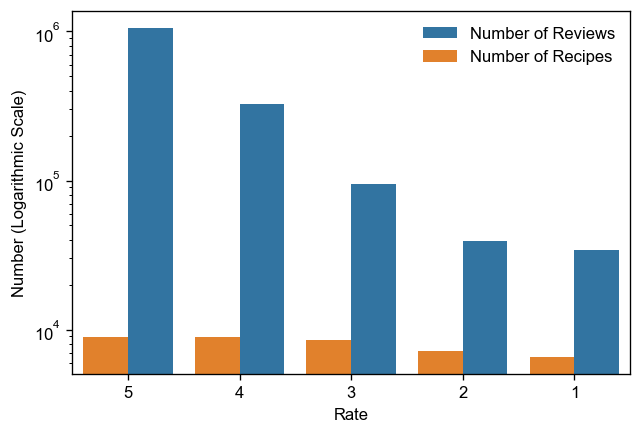

In [718]:
####################################################################################
# The rate is from 1 to 5. How many reviews and recipes fall in each category?
####################################################################################
data=pd.DataFrame({'Rate':[5, 4, 3, 2, 1],
                  'Number of Reviews': list(reviews.groupby(by='Rate')['RecipeID'].count().sort_index(ascending=False)),
                  'Number of Recipes': list(reviews.groupby(by='Rate')['RecipeID'].nunique().sort_index(ascending=False))
                  })

fig, ax=plt.subplots(1, 1)
sns.barplot(x='Rate', y='Value', hue='Variable', data=data.melt(id_vars='Rate').rename(columns=str.title), ax=ax)
ax.set_yscale('log')
ax.set_xlim(4.5, -0.5)
#ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.set_xlabel('Rate')
ax.set_ylabel('Number (Logarithmic Scale)')
plt.legend(frameon=False)
plt.show()

It's clear that the qualities of recipes are quite evenly distributed. However, better recipes are more popular and attract more reviewers.    

In [719]:
############################################################################################
# What are the ranks of recipes look like?
############################################################################################
# Considering using the table below to calculate a score for each recipe
# =========================================================
# Star     |      5         4       3       2        1
# ---------------------------------------------------------
# Score    |    100        75      50      25        0
# ---------------------------------------------------------
# Meaning  | Very Good    Good    Fair   Poor   Very Poor
# =========================================================
############################################################################################
recipe_ID=list(reviews.groupby(by=['RecipeID'])['profileID'].count().index)
recipe_name=[]
for id in recipe_ID:
    recipe_name.append(recipes.loc[recipes['RecipeID']==id, 'Recipe Name'].values[0])
assert len(recipe_ID)==len(recipe_name)

In [720]:
#######################################################################################################################
# Calculate score for each recipe
# Score=100*(number of 5 star)+75*(number of 4 star)+50*(number of 3 star)+25*(number of 2 star)+0*(number of 1 star)
# For each recipe, calculate how many 5 star, 4 star, 3 star, 2 star, and 1 star it got
#######################################################################################################################
score=[]
star5=[]
star4=[]
star3=[]
star2=[]
star1=[]
ratings=reviews.groupby(['RecipeID', 'Rate'])['Rate'].count()
for id in tqdm.tqdm(recipes['RecipeID']):
    dataframe=ratings.loc[pd.IndexSlice[id, 1:5], :].rename('Count')
    inner_index=dataframe.index.get_level_values(level=1)
    inner_index_weight=pd.Series(inner_index).replace({5:100, 4:75, 3:50, 2:25, 1:0})
    this_score=0
    this_star=[0,0,0,0,0] # star 5 to star 1
    for index, weight in zip(inner_index, inner_index_weight):
        count_value=dataframe[dataframe.index.get_level_values(level=1)==index].values[0]
        this_score=this_score+weight*count_value
        if index==5:
            this_star[0]=count_value
        elif index==4:
            this_star[1]=count_value
        elif index==3:
            this_star[2]=count_value
        elif index==2:
            this_star[3]=count_value
        else:
            this_star[4]=count_value
    score.append(this_score)
    star5.append(this_star[0])
    star4.append(this_star[1])
    star3.append(this_star[2])
    star2.append(this_star[3])
    star1.append(this_star[4])
assert len(score)==len(recipe_ID)==len(recipe_name)==len(star5)==len(star4)==len(star3)==len(star2)==len(star1)

100%|█████████████████████████████████████████████████████████████████████████████| 8908/8908 [01:08<00:00, 129.15it/s]


In [721]:
############################################################################################
# Build the recipe score data frame
############################################################################################
recipe_score_data=pd.DataFrame({
    'Recipe Name': recipe_name,
    'Score': score,
    'Star 5': star5,
    'Star 4': star4,
    'Star 3': star3,
    'Star 2': star2,
    'Star 1': star1
}, index=recipe_ID)
recipe_score_data.index.name='RecipeID'
recipe_score_data.sort_values(by='Score', ascending=False).head(20)

,Recipe Name,Score,Star 5,Star 4,Star 3,Star 2,Star 1
RecipeID,,,,,,,
13838,Sugar Coated Pecans Recipe,97000,933,41,11,3,2
24952,Caramel Popcorn Recipe,95725,905,61,8,10,6
13436,Italian Sausage Soup with Tortellini Recipe,95625,890,76,16,5,3
20669,Double Tomato Bruschetta Recipe,95250,878,89,12,7,4
19163,Luscious Slush Punch Recipe,95250,883,82,14,4,7
17690,Sweet Dinner Rolls Recipe,95075,883,75,20,6,6
19484,Grilled Marinated Shrimp Recipe,94950,874,84,19,12,1
23822,Pumpkin Gingerbread Recipe,94950,861,102,23,2,2
20156,Clone of a Cinnabon Recipe,94950,886,69,21,5,9


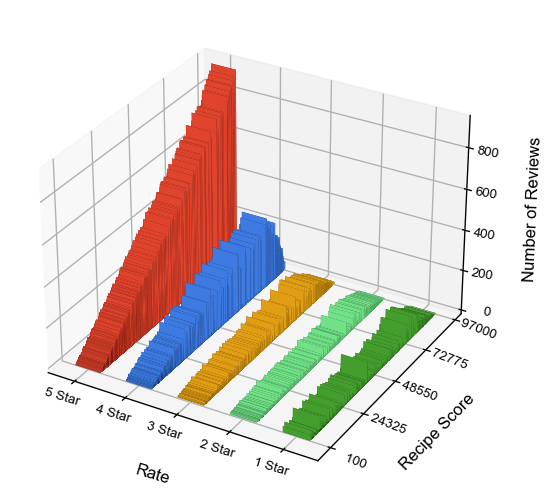

In [722]:
############################################################################################
# Plot 3-D bar
############################################################################################
data=recipe_score_data.sort_values(by='Score', ascending=False)[:]
#==============================================================
fig=plt.figure()
ax=Axes3D(fig)
lx=5          
ly=len(data.index)
xpos=np.arange(0,lx,1)    
ypos=data['Score']
xpos, ypos=np.meshgrid(xpos-0.2, ypos)
xpos=xpos.flatten()   
ypos=ypos.flatten()
zpos=np.zeros(lx*ly)

dx=0.5*np.ones_like(zpos)
dy=dx.copy()
dz=data[['Star 5', 'Star 4', 'Star 3', 'Star 2', 'Star 1']].values.flatten()
cs=[(1, 0.3, 0.2), (0.27,0.54,1), (1, 0.7, 0.09), (0.5, 1, 0.6), (0.3, 0.7, 0.2)]*ly
ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=cs)
ax.set_xlabel('Rate', rotation=(-17))
ax.set_ylabel('Recipe Score')
ax.set_zlabel('Number of Reviews')
ax.set_xticks([i for i in range(5)])
ax.set_xticklabels(rotation=(-17), fontsize=8, va='bottom', ha='center', 
                   labels=['5 Star', '4 Star', '3 Star', '2 Star', '1 Star'])
ax.set_yticks([i+2000 for i in np.linspace(data.iloc[0, 1], data.iloc[-1, 1], num=5, endpoint=True)])
y_labels=['  {:.0f}'.format(x) for x in np.linspace(data.iloc[0, 1], data.iloc[-1, 1], num=5, endpoint=True)] 
ax.set_yticklabels(rotation=(-21), fontsize=8, va='bottom', ha='center', labels=y_labels)
ax.set_zticks([x for x in np.linspace(0, 800, num=5, endpoint=True)])
ax.set_zticklabels(rotation=(-10), fontsize=8, va='top', ha='right', labels=[0, 200, 400, 600, 800])
plt.show()

It seems that 5 star and 4 star reviews have occupied the majority of the total reviews. The recipes are distributed in a wide range of recipe score (from 100 to 97000), indicating a large variation of quality and popularity level of the recipes. Also the recipes are evenly distributed in the range, and there are no obvious gaps. The recipe score is a good indicator for our study.

In [723]:
#################################################
# Save the cleaned data
#################################################
with open('..\\data\\processed\\recipes.pkl', 'wb') as file:
    pickle.dump(recipes, file)
with open('..\\data\\processed\\reviews.pkl', 'wb') as file:
    pickle.dump(reviews, file)
with open('..\\data\\processed\\scores.pkl', 'wb') as file:
    pickle.dump(recipe_score_data, file)

### Pre-processing and Training

Our interest is to find out what combination of food materials and seasoners would lead to good recipes. Therefore we need to extract the information about the food materials and seasoners from recipes, and figure out what a good or bad combinations look like. 

In [2]:
##################################################
# Load the cleaned data
##################################################
with open('..\\data\\processed\\recipes.pkl', 'rb') as file:
    recipes=pickle.load(file)
with open('..\\data\\processed\\reviews.pkl', 'rb') as file:
    reviews=pickle.load(file)
with open('..\\data\\processed\\scores.pkl', 'rb') as file:
    scores=pickle.load(file)

### Modeling and Prediction

### Conclusion

### References
[1] Kiddon, Chloé, Luke Zettlemoyer, and Yejin Choi. "Globally coherent text generation with neural checklist models." In Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing, pp. 329-339. 2016.

[2] Majumder, Bodhisattwa Prasad, Shuyang Li, Jianmo Ni, and Julian McAuley. "Generating personalized recipes from historical user preferences." arXiv preprint arXiv:1909.00105 (2019).

[3] https://www.kaggle.com/kanaryayi/recipe-ingredients-and-reviews. 

